<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fontes-de-ruído-em-receptores-ópticos" data-toc-modified-id="Fontes-de-ruído-em-receptores-ópticos-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fontes de ruído em receptores ópticos</a></span><ul class="toc-item"><li><span><a href="#Ruído-de-disparo-(ou-ruído-balístico)" data-toc-modified-id="Ruído-de-disparo-(ou-ruído-balístico)-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Ruído de disparo (ou ruído balístico)</a></span></li><li><span><a href="#Potência-do-ruído-de-disparo" data-toc-modified-id="Potência-do-ruído-de-disparo-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Potência do ruído de disparo</a></span><ul class="toc-item"><li><span><a href="#Calculando-a-potência-de-um-sinal" data-toc-modified-id="Calculando-a-potência-de-um-sinal-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Calculando a potência de um sinal</a></span></li></ul></li><li><span><a href="#Ruído-térmico" data-toc-modified-id="Ruído-térmico-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Ruído térmico</a></span></li><li><span><a href="#Potência-de-ruído-térmico" data-toc-modified-id="Potência-de-ruído-térmico-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Potência de ruído térmico</a></span></li><li><span><a href="#Razão-sinal-ruído-(signal-to-noise-ratio---SNR)" data-toc-modified-id="Razão-sinal-ruído-(signal-to-noise-ratio---SNR)-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Razão sinal-ruído (<em>signal-to-noise ratio</em> - SNR)</a></span></li><li><span><a href="#Receptores-p-i-n" data-toc-modified-id="Receptores-p-i-n-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Receptores p-i-n</a></span><ul class="toc-item"><li><span><a href="#Limite-de-ruído-térmico-$(\sigma_{T}^{2}-\gg-\sigma_{s}^{2})$" data-toc-modified-id="Limite-de-ruído-térmico-$(\sigma_{T}^{2}-\gg-\sigma_{s}^{2})$-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Limite de ruído térmico $(\sigma_{T}^{2} \gg \sigma_{s}^{2})$</a></span></li><li><span><a href="#Limite-de-ruído-de-disparo-$(\sigma_{s}^{2}-\gg-\sigma_{T}^{2})$" data-toc-modified-id="Limite-de-ruído-de-disparo-$(\sigma_{s}^{2}-\gg-\sigma_{T}^{2})$-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Limite de ruído de disparo $(\sigma_{s}^{2} \gg \sigma_{T}^{2})$</a></span></li><li><span><a href="#Parâmetros-típicos" data-toc-modified-id="Parâmetros-típicos-1.6.3"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Parâmetros típicos</a></span></li></ul></li><li><span><a href="#Simulando-o-transmissor-10G-OOK" data-toc-modified-id="Simulando-o-transmissor-10G-OOK-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Simulando o transmissor 10G OOK</a></span></li><li><span><a href="#Simulando-as-fontes-de-ruído-do-receptor-p-i-n" data-toc-modified-id="Simulando-as-fontes-de-ruído-do-receptor-p-i-n-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Simulando as fontes de ruído do receptor p-i-n</a></span></li><li><span><a href="#Receptores-baseados-em-APDs" data-toc-modified-id="Receptores-baseados-em-APDs-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Receptores baseados em APDs</a></span><ul class="toc-item"><li><span><a href="#Ruído-de-disparo" data-toc-modified-id="Ruído-de-disparo-1.9.1"><span class="toc-item-num">1.9.1&nbsp;&nbsp;</span>Ruído de disparo</a></span></li></ul></li></ul></li><li><span><a href="#Sensitividade-de-receptores" data-toc-modified-id="Sensitividade-de-receptores-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sensitividade de receptores</a></span><ul class="toc-item"><li><span><a href="#Canal-AWGN-(Additive-White-Gaussian-Noise-Channel)" data-toc-modified-id="Canal-AWGN-(Additive-White-Gaussian-Noise-Channel)-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Canal AWGN (<em>Additive White Gaussian Noise Channel</em>)</a></span></li><li><span><a href="#Filtragem-no-receptor" data-toc-modified-id="Filtragem-no-receptor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Filtragem no receptor</a></span></li><li><span><a href="#Filtro-casado" data-toc-modified-id="Filtro-casado-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Filtro casado</a></span></li><li><span><a href="#Decisor-ótimo:-avaliando-probabilidades" data-toc-modified-id="Decisor-ótimo:-avaliando-probabilidades-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Decisor ótimo: avaliando probabilidades</a></span><ul class="toc-item"><li><span><a href="#Métrica-de-probabilidades-a-posteriori-(MP)" data-toc-modified-id="Métrica-de-probabilidades-a-posteriori-(MP)-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Métrica de <em>probabilidades a posteriori</em> (MP)</a></span></li><li><span><a href="#Limiar-de-decisão-ótimo-$I_d$" data-toc-modified-id="Limiar-de-decisão-ótimo-$I_d$-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Limiar de decisão ótimo $I_d$</a></span></li></ul></li><li><span><a href="#Probabilidade-de-erro-de-bit-$P_b$" data-toc-modified-id="Probabilidade-de-erro-de-bit-$P_b$-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Probabilidade de erro de bit $P_b$</a></span><ul class="toc-item"><li><span><a href="#Exemplo:-simulação-10G-OOK" data-toc-modified-id="Exemplo:-simulação-10G-OOK-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Exemplo: simulação 10G OOK</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from numpy.random import normal
from scipy import constants
from commpy.utilities  import signal_power, upsample
from utils.dsp import firFilter, pulseShape, eyediagram, lowPassFIR
from utils.models import mzm
from numpy.fft import fft, ifft, fftshift, fftfreq

In [2]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
figsize(10, 3)

# Comunicações Ópticas

# Detecção de sinais ópticos e ruído


<img src="./figuras/Rx_OOK.png" width="400">

## Fontes de ruído em receptores ópticos


Ruídos são distorções aleatórias e indesejáveis que afetam os sinais que carregam informação, dificultando ou impossibilitando o processo de comunicação. Para analisarmos o desempenho de um dado sistemas de comunicações é necessário que todas as fontes de ruído presentes no mesmo estejam caracterizadas. No caso de receptores em sistemas de comunicações ópticas, duas fontes de ruído são importantes: o ruído de disparo gerado no processo de fotodetecção e o ruído térmico dos componentes eletrônicos.

### Ruído de disparo (ou ruído balístico)

A corrente $I(t)$ gerada pela conversão da potência de sinal óptico incidente no fotodiodo pode ser escrita como

$$
\begin{equation}\label{eq1}
I(t)=I_{p}(t) + i_{s}(t)
\end{equation}
$$

em que $i_{s}(t)$ representa um processo aleatório conhecido como ruído de disparo e $I_{p}(t)$ corresponde à corrente proporcional à responsividade e à potência óptica incidente no fotodiodo, data por

$$
\begin{equation}\label{eq2}
I_{p}(t)=R_{d} P_{\text {in}}(t).
\end{equation}
$$

O ruído de disparo $i_{s}(t)$ é bem caracterizado como um processo aleatório estacionário com estatística de Poisson que, em geral, é aproximada por uma estatística gaussiana, o que facilita o seu tratamento matemático.

Seja $R_{i_s}(\tau)$ a função de autocorrelação de $i_s(t)$ será dada por

$$
\begin{equation} \label{eq3}
R_{i_s}(\tau) = E\left[i_s(t)i_s(t+\tau)\right].
\end{equation}
$$

Pelo teorema de Wiener-Kinchin, a densidade espectral e potência $S_{i_s}(f)$ associada a $i_s(t)$ é dada pela transformada de Fourier de $R_{i_s}(\tau)$, de modo que 

$$
\begin{align}
S_{i_s}(f)    &= \int_{-\infty}^{\infty}R_{i_s}(\tau)e^{-2\pi f \tau} d\tau\nonumber \\
R_{i_s}(\tau) &= \int_{-\infty}^{\infty}S_{i_s}(f)e^{2\pi f \tau} df\label{eq4}
\end{align}
$$

No caso do ruído de disparo, a densidade espectral de potência é constante e dada por $S_{i_s}(f)=q\bar{I}_p$, em que 
$\bar{I}_p$ é o valor médio da fotocorrente, definido por

$$
\begin{equation}\label{eq5}
\bar{I}_p = \frac{1}{T_s} \int_{-T_s/2}^{T_s/2}E[I_p(t)]dt.
\end{equation}
$$

em que $T_s$ é o período de sinalização da transmissão.

### Potência do ruído de disparo

A potência do ruído de disparo corresponderá a sua variância $\sigma_{s}^{2}$. Seja $B$ a banda do receptor óptico em $Hz$, $\sigma_{s}^{2}$ pode ser calculada por

$$
\begin{align}
\sigma_{s}^{2} &= E\left[i_{s}^{2}(t)\right] = R_{i_s}(0) \nonumber\\
               &= \int_{-\infty}^{\infty} S_{i_s}(f) df = \int_{-B}^{B} S_{i_s}(f) df \nonumber \\
               &= 2 q \bar{I}_{p} B \label{eq6}
\end{align}
$$

Uma vez que a corrente de escuro $I_d$ do fotodiodo (*dark current*) também contribui para o ruído de disparo, a mesma deve ser incluída em (\ref{eq6}), de modo que a expressão final para a variância do ruído de disparo será dada por

$$
\begin{equation}\label{eq7}
\sigma_{s}^{2} = 2 q (\bar{I}_{p} + I_d) B.
\end{equation}
$$


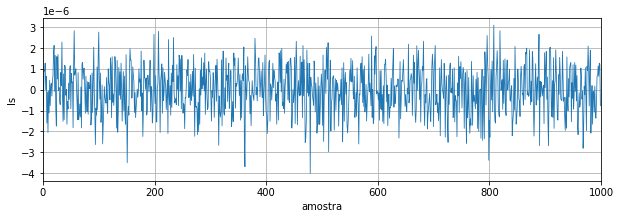

In [4]:
Pin_dBm = -1   # potência óptica média em dBm
Rd  = 0.5      # responsividade em A/W
Id  = 100e-9   # corrente de escuro em nA
B   = 10e9     # banda do receptor em Hz

q  = constants.value('elementary charge') # carga elementar do elétron

Pin = 10**(Pin_dBm/10)*1e-3 # potência óptica média em W
Ip  = Rd*Pin

# ruído de disparo (ruído gaussiano branco)
Namostras = 100000

σ2_s = 2*q*(Ip + Id)*B  # variância
μ    = 0                # média

σ     = np.sqrt(σ2_s) 
Is    = normal(μ, σ, Namostras)  

# plotas as primeiras 1000 amostras
plt.plot(Is[0:1000],linewidth = 0.8);
plt.xlim(0,1000)
plt.ylabel('Is')
plt.xlabel('amostra')
plt.grid()

In [5]:
# fdp de uma variável aleatória gaussiana de média μ e desvio padrão σ
def gaussian(x, μ, σ):
    return np.exp(-((x - μ)**2)/(2*σ**2))/np.sqrt(2*np.pi*σ**2)

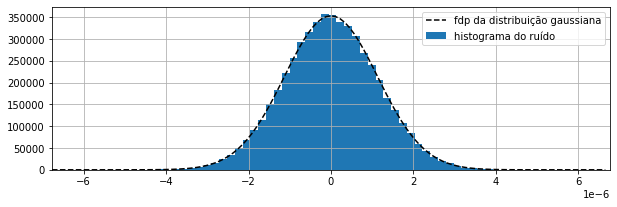

In [6]:
plt.hist(Is,51, density=True, label = 'histograma do ruído');
plt.grid()

x   = np.arange(-6*σ,6*σ, σ/10)
fdp = gaussian(x,μ,σ)

plt.plot(x,fdp,'k--',label ='fdp da distribuição gaussiana');
plt.legend();
plt.xlim(-6*σ,6*σ);

<IPython.core.display.Math object>

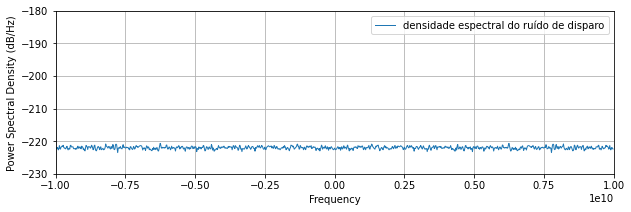

In [7]:
fa = 20e9   # frequência de amostragem considerada

plt.figure()
plt.xlim(-fa/2, fa/2)
plt.ylim(-230, -180)
plt.psd(Is, Fs=fa, label='densidade espectral do ruído de disparo',\
                   linewidth=1,  sides='twosided', NFFT=1024); # estima densidade espectral de potência do sinal
plt.legend()

display(Math('S_{i_s}(f) = %.2f \;\mathrm{dBW/Hz}'%(10*np.log10(σ2_s/(2*B)))))

#### Calculando a potência de um sinal

$$\begin{equation}\label{eq8}
P_x = E\left[X^2\right] = \mu^2 + \sigma^2\approx \frac{1}{N}\sum_{k=1}^{N} x^2[k]
\end{equation}
$$

In [8]:
Pn = signal_power(Is)

print('Potência do ruído (em W)   = %.2e W' %Pn) 
print('Potência do ruído (em dBm) = %.2f dBm' %(10*np.log10(Pn/1e-3))) 

Potência do ruído (em W)   = 1.27e-12 W
Potência do ruído (em dBm) = -88.96 dBm


### Ruído térmico

O ruído térmico tem sua origem na agitação térmica dos elétrons presentes no material que constitui um determinado dispositivo eletrônico submetido a uma dada temperatura. Desse modo, os circuitos eletrônicos que compõem o *front-end* dos receptores em sistemas de comunicação naturalmente adicionam ruído térmico aos sinais detectados. Portanto, num receptor óptico, os circuitos microeletrônicos responsáveis por processar o sinal elétrico obtido no processo de fotodetecção também serão fontes de ruído térmico.

Assim como o ruído de disparo, o ruído térmico tem características additivas e pode ser modelado por um processo aleatório gaussiano estacionário. Logo, podemos reescrever a equação (\ref{eq1}) adicionando a componente de ruído térmico $i_{T}(t)$, de modo que

$$
\begin{equation}\label{eq9}
I(t)=I_{p}+i_{s}(t)+i_{T}(t)
\end{equation}
$$

A densidade espectral de potência $S_{T}(f)$ do ruído térmico é constante e independente da frequência até $\sim 1 \mathrm{THz}$ e dada por

$$
\begin{equation}\label{eq10}
S_{T}(f) =2 k_{B} T/R_{L}
\end{equation}
$$

em que $k_B$ é a constante Boltzmann, $T$ é a temperatura na escala Kelvin e $R_L$ é o resistor de carga.

### Potência de ruído térmico

Novamente fazendo uso das propriedades da densidade espectral de potência, temos

$$
\begin{align}
\sigma_{T}^{2} &=E\left[ i_{T}^{2}(t)\right]\nonumber\\
               &=\int_{-\infty}^{\infty} S_{T}(f) df\nonumber\\
               &=\int_{-B}^{B} S_{T}(f) df\nonumber\\
               &=\left(4 k_{B} T / R_{L}\right) B\label{eq11}
\end{align}
$$

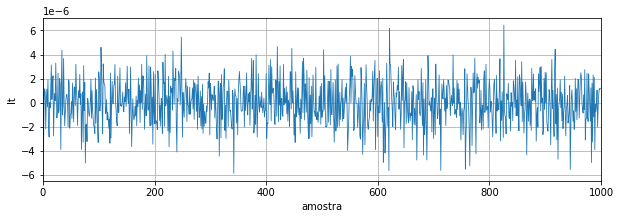

In [9]:
Tc = 25           # temperatura em Celsius
B  = 10e9         # banda do receptor
RL = 50           # RL em Ohms

T = Tc + 273.15   # temperatura em Kelvin


kB  = constants.value('Boltzmann constant')

# ruído térmico (ruído gaussiano branco)
Namostras = 100000

σ2_T = 4*kB*T*B/RL  # variância
μ    = 0            # média

σ     = np.sqrt(σ2_T) 
It    = normal(μ, σ, Namostras)  

# plotas as primeiras 1000 amostras
plt.plot(It[0:1000],linewidth = 0.8);
plt.xlim(0,1000)
plt.ylabel('It')
plt.xlabel('amostra')
plt.grid()

<IPython.core.display.Math object>

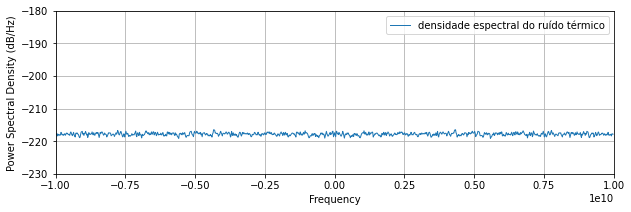

In [10]:
fa = 20e9   # frequência de amostragem considerada

plt.figure()
plt.xlim(-fa/2, fa/2)
plt.ylim(-230, -180)
plt.psd(It, Fs=fa, label='densidade espectral do ruído térmico',linewidth=1,  sides='twosided', NFFT=1024); # estima densidade espectral do sinal
plt.legend()

display(Math('S_{i_T}(f) = %.2f \;\mathrm{dBW/Hz}'%(10*np.log10(σ2_T/(2*B)))))

In [11]:
Pn = signal_power(It)

print('Potência do ruído (em W)   = %.2e W' %Pn) 
print('Potência do ruído (em dBm) = %.2f dBm' %(10*np.log10(Pn/1e-3))) 

Potência do ruído (em W)   = 3.30e-12 W
Potência do ruído (em dBm) = -84.82 dBm


Amplificadores elétricos utilizados em receptores ópticos invariavelmente adicionam ruído aos sinais sendo amplificados. O efeito da adição de ruído térmico no processo de amplificação é genericamente caracterizado pelo parâmetro de *figura de ruído* $F_n$ do dispositivo, de modo que

$$
\begin{equation}\label{eq12}
\sigma_{T}^{2}= \left(4 k_{B}T/ R_{L}\right) F_{n} B
\end{equation}
$$

O ruído total $i_n(t)$ adicionado pelo receptor será dado por $i_n(t) = i_s(t) + i_T(t)$, de modo que

$$
\begin{equation}\label{eq13}
\sigma_n^{2}=E\left[I_n^{2}\right]=\sigma_{s}^{2}+\sigma_{T}^{2}=2 q\left(\bar{I}_{p}+I_{d}\right) B +\left(4 k_{B}T/ R_{L}\right) F_{n} B
\end{equation}
$$

### Razão sinal-ruído (*signal-to-noise ratio* - SNR)

A relação sinal-ruído (ou razão sinal-ruído, *signal-to-noise ratio* (SNR), em Inglês) é uma das grandezas mais importantes na engenharia de sistemas de comunicações. A SNR é uma medida da influência do ruído num dado sistema.

A SNR é definida como sendo a razão entre a potência de sinal $P_s$ e a potência do ruído $P_n$ observadas num dado sistema, ou seja

$$
\begin{equation}\label{eq14}
\mathrm{SNR} = \frac{P_s}{P_n}
\end{equation}
$$

em que $P_s = E\left[|s(t)|^2\right]$ e $P_n=E\left[|n(t)|^2\right]$.

Quando expressa em decibéis (dB), a SNR é dada por

$$ 
\begin{equation}\label{eq15}
\mathrm{SNR}_{dB} = 10\log_{10}P_s-10\log_{10}P_n.
\end{equation}
$$

Quanto maior a SNR maior a diferença entre a potência do sinal de interesse e a potência do ruído adicionado á mesma. Dessa forma, quanto maior a SNR melhor a qualidade do sinal.

### Receptores p-i-n

Para receptores p-i-n, considerando a presença de ruído de disparo e ruído térmico, temos a seguinte expressão para a SNR do sinal elétrico na saída do fotodiodo

$$
\begin{equation}\label{eq16}
\mathrm{SNR}=\frac{R_{d}^{2} P_{i n}^{2}}{2 q\left(R_{d} P_{i n}+I_{d}\right)B + 4\left(k_{B} T / R_{L}\right) F_{n} B}.
\end{equation}
$$

#### Limite de ruído térmico $(\sigma_{T}^{2} \gg \sigma_{s}^{2})$

$$
\begin{equation}\label{eq17}
\mathrm{SNR}=\frac{R_{L} R_{d}^{2} P_{\text {in }}^{2}}{4 k_{B} T F_{n} \Delta f}
\end{equation}
$$

Potência equivalente de ruído (*noise-equivalent power* - $\mathrm{NEP}$)

$$
\begin{equation}\label{eq18}
\mathrm{NEP}=\frac{P_{\mathrm{in}}}{\sqrt{\Delta f}}=\left(\frac{4 k_{\mathrm{B}} T F_{n}}{R_{L} R_{d}^{2}}\right)^{1 / 2}=\frac{h \nu}{\eta q}\left(\frac{4 k_{\mathrm{B}} T F_{n}}{R_{\mathrm{L}}}\right)^{1 / 2}
\end{equation}
$$

#### Limite de ruído de disparo $(\sigma_{s}^{2} \gg \sigma_{T}^{2})$

$$
\begin{equation}\label{eq19}
\mathrm{SNR}=\frac{R_{d} P_{\mathrm{in}}}{2 q \Delta f}=\frac{\eta P_{\mathrm{in}}}{2 h \nu \Delta f}
\end{equation}
$$

#### Parâmetros típicos

$$
\begin{array}{lcclll}
\hline
\text { Parâmetro } & \text { Símbolo } & \text { Unidade } & \text { Si } & \text { Ge } & \text { InGaAs } \\
\hline \text { Comprimento de onda } & \lambda & \mu \mathrm{m} & 0,4-1,1 & 0,8-1,8 & 1,0-1,7 \\
\text { Responsividade } & R_{d} & \mathrm{~A} / \mathrm{W} & 0,4-0,6 & 0,5-0,7 & 0,6-0,9 \\
\text { Eficiência quântica } & \eta & \% & 75-90 & 50-55 & 60-70 \\
\text { Corrente no escuro } & I_{d} & \mathrm{n} \mathrm{A} & 1-10 & 50-500 & 1-20 \\
\text { Tempo de subida } & T_{r} & \mathrm{~ns} & 0,5-1 & 0,1-0,5 & 0,02-0,5 \\
\text { Largura de banda } & \Delta f & \mathrm{GHz} & 0,3-0,6 & 0,5-3 & 1-10 \\
\text { Tensão de polarização } & V_{b} & \mathrm{~V} & 50-100 & 6-10 & 5-6 \\
\hline
\end{array}
$$
<center> Fonte: Tabela 4.1, Agrawal, Sistemas de Comunicações por Fibra Óptica, 4ª edição, 2014. </center>

### Simulando o transmissor 10G OOK

Potência média do sinal óptico modulado (mW): 0.01 mW
Potência média do sinal óptico modulado (dBm): -20.04 dBm


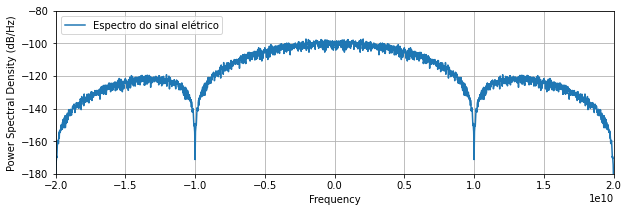

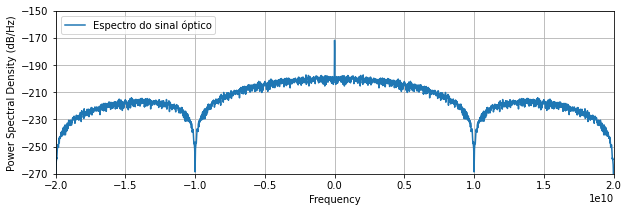

In [12]:
# parâmetros da simulação
SpS = 16

Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

Pi_dBm = -17  # potência de sinal óptico na entrada do modulador em dBm

# parâmetros do MZM
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# gera sequência de bits pseudo-aleatórios
bits   = np.random.randint(2, size=10000)    
n      = np.arange(0, bits.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bits-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso NRZ típico
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai     = np.sqrt(Pi)
sigTxo = mzm(Ai, Vπ, sigTx, Vb)

print('Potência média do sinal óptico modulado (mW): %.2f mW'%(signal_power(sigTxo)/1e-3))
print('Potência média do sinal óptico modulado (dBm): %.2f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

# plota psd
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-180,-80);
plt.psd(sigTx,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal elétrico')
plt.legend(loc='upper left');

# plota psd
plt.figure();
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-270,-150);
plt.psd(np.abs(sigTxo)**2,Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal óptico')
plt.legend(loc='upper left');

### Simulando as fontes de ruído do receptor p-i-n

Pin[Rx] = -20.04 dBm 
SNR[teoria] = 16.07 dB 
SNR[sim] = 16.00 dB 


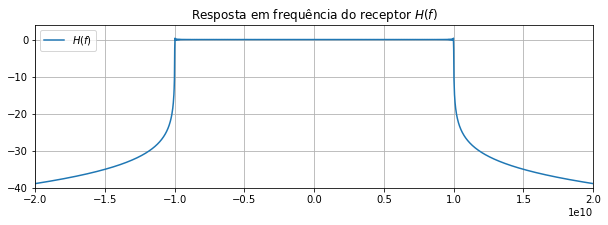

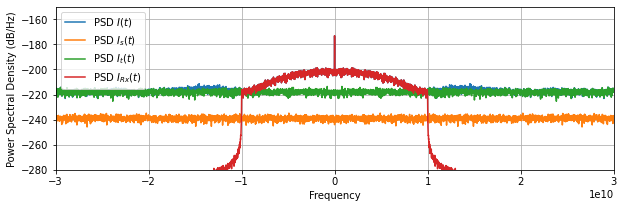

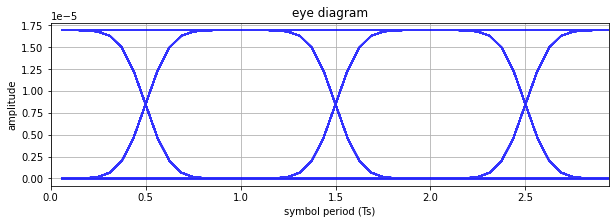

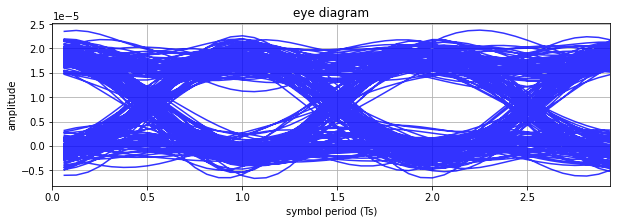

In [13]:
# parâmetros do receptor
Tc  = 25        # temperatura em Celsius
B   = 10e9      # banda do receptor em Hz
Rd  = 0.85      # responsividade em A/W
Id  = 5e-9      # corrente de escuro em nA
RL  = 50        # RL em Ohms

Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# fotocorrente livre de ruído
Ip = Rd*np.abs(sigTxo)**2

# ruído de disparo 
σ2_s = 2*q*(Rd*Pin + Id)*B  # variância  

# ruído térmico
T = Tc + 273.15     # temperatura em Kelvin
σ2_T = 4*kB*T*B/RL  # variância do ruído térmico

# adiciona ruído do receptor p-i-n aos sinais
Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

I = Ip + Is + It

# filtragem Rx
N = 8001
h = lowPassFIR(B, Fa, N, typeF='rect')

freq = fftshift(fftfreq(h.size, d=1/Fa))
plt.figure()
plt.plot(freq, 10*np.log10(np.abs(fftshift(fft(h)))),label='$H(f)$')
plt.legend(loc='upper left');
plt.xlim(-2*Rs,2*Rs);
plt.ylim(-40,4);
plt.title('Resposta em frequência do receptor $H(f)$')
plt.grid();

I_Rx  = firFilter(h, I)

# plota psds
plt.figure();
plt.xlim(-3*Rs,3*Rs);
plt.ylim(-280,-150);
plt.psd(I, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'PSD $I(t)$')
plt.psd(Is, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'PSD $I_s(t)$')
plt.psd(It, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'PSD $I_t(t)$')
plt.psd(I_Rx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'PSD $I_{Rx}(t)$')
plt.legend(loc='upper left');

Nsamples = 10000

# calculando a na simulação SNR
Ip_Rx  = firFilter(h, Ip)
Is_Rx  = firFilter(h, Is)
It_Rx  = firFilter(h, It)

# SNR teórica [Eq. (16)]
SNR_th  = (Ip**2).mean()/(σ2_s + σ2_T)

# SNR estimada numericamente na simulação
SNR_est = (Ip_Rx**2).mean()/(Is_Rx**2 + It_Rx**2).mean()

print('Pin[Rx] = %.2f dBm '%(10*np.log10(Pin/1e-3)))
print('SNR[teoria] = %.2f dB '%(10*np.log10(SNR_th)))
print('SNR[sim] = %.2f dB '%(10*np.log10(SNR_est)))

# diagrama de olho
eyediagram(Ip,  Nsamples, SpS)
eyediagram(I_Rx, Nsamples, SpS)

### Receptores baseados em APDs

A fotocorrente gerada por um fotodiodo de avalanche (*avalanche photodiode* - APD) é dada por

$$
\begin{equation}\label{eq20}
I_{p}=M R_{d} P_{i n}=R_{\mathrm{APD}} P_{\mathrm{in}}
\end{equation}
$$

em que $R_{\mathrm{APD}} \equiv M R_{d}$ é a responsividade do APD e $M$ o fator multiplicativo associado.

#### Ruído de disparo

A potência de ruído de disparo de um APD é dada por
$$
\begin{equation}\label{eq21}
\sigma_{s}^{2}=2 q M^{2} F_{A}\left(R_{d} P_{\mathrm{in}}+I_{d}\right) \Delta f,
\end{equation}
$$

em que $F_{A}$ é o fator de excesso de ruído, dado por

$$
\begin{equation}\label{eq22}
F_{A}(M)=k_{A} M+\left(1-k_{A}\right)(2-1 / M).
\end{equation}
$$

$$
\begin{equation}\label{eq23}
\mathrm{SNR}=\frac{I_{p}^{2}}{\sigma_{s}^{2}+\sigma_{T}^{2}}=\frac{\left(M R_{d} P_{\text {in }}\right)^{2}}{2 q M^{2} F_{A}\left(R_{d} P_{\text {in }}+I_{d}\right) \Delta f+4\left(k_{B} T / R_{L}\right) F_{n} \Delta f}
\end{equation}
$$

## Sensitividade de receptores

Uma vez presente no sistema, o ruído impõe limitações no desempenho dos receptores e, consequentemente, nas taxas de transmissão que podem ser atingidas pelo sistema de comunicação.

Um dos parâmetros desempenho mais importantes em receptores ópticos digitais é a taxa de erro de bits (*bit-error rate* - BER) que indica a frequência em que o circuito decisor comete um erro na identificação de um bit transmitido a partir do sinal recebido. Por exemplo, se o circuito decisor comete em média um erro a cada um milhão de bits transmitidos, temos uma $\mathrm{BER} = 1/10^6=1 \times 10^{-6}$. Os padrões adotados na engenheria de sistemas de comunicações ópticas geralmente requerem valores de BER $< 10^{-9}$, ou $<10^{-12}$.

A BER de um dado sistema, por sua vez, depende dos valores de SNR dos sinais detectados no receptor. Como visto anteriormente, a SNR depende diretamente da potência de sinal óptico $P_{in}$ presente na entrada do receptor. Um parâmetro comum associado a todo receptor óptico é a *sensitividade*, que se refere ao menor valor de potência recebida necessário para que o receptor opere com uma certa BER.


### Canal AWGN (*Additive White Gaussian Noise Channel*)

Assumindo que sinal óptico detectado gera um sinal elétrico $y(t)$ que corresponde ao sinal transmitido $x(t)$ somado ao sinal $n(t)$, resultante da adição do ruído de disparo e do ruído térmico no *front-end* do receptor, temos que

$$
\begin{align}
y(t) &= x(t) + n(t)\nonumber\\
     &= \sum_k s_kp(t-kT_s) + n(t).
\end{align}
$$

Por simplicidade e sem perda de generalidade, assumimos que o sinal elétrico $x(t)$ possui média nula.

### Filtragem no receptor

<img src="./figuras/MF.png" width="500">

Primeiramente, o sinal recebido $y(t)$ deve passar por um filtro de resposta ao impulso $h(t)$, cuja função é eliminar componentes de ruído fora da banda de $x(t)$ e entregar o um sinal $\hat{y}(t)$ com um máximo de SNR para o circuito decisor. Logo,

$$
\begin{align}
\hat{y}(t) &= y(t) \ast h(t)\nonumber\\
           &= \left[\sum_k s_kp(t-kT_s)\right]\ast h(t)  + n(t)\ast h(t)\nonumber\\
           &= \sum_k s_k\int_{-\infty}^{-\infty}p(\tau-kT_s)h(t-\tau)d\tau  + \int_{-\infty}^{-\infty}n(t)h(t-\tau)d\tau\nonumber\\
           &= \hat{x}(t)  + \hat{n}(t).
\end{align}
$$

Em seguida, o sinal $\hat{y}(t)$ será amostrado nos instantes $t=kT_s$, ou seja, no meio do intervalo de sinalização, onde sua SNR é máxima. Para cada intervalo de sinalização, o circuito decisisor receberá uma amostra $\hat{y}(kT_s)$ dada por

$$
\begin{equation}
\hat{y}(kT_s) = \hat{x}(kT_s) + \hat{n}(kT_s).             
\end{equation}
$$

Dessa forma, podemos agora calcular a SNR do sinal $\hat{y}(kT_s)$ entregue ao circuito decisor. Para a potência de sinal, $P_s$, temos que

$$
\begin{align}
P_s &= E[\hat{x}(kT_s)^2] \nonumber\\
    &= E\left[ \left(s_k\int_{-\infty}^{-\infty}p(\tau-kT_s)h(kT_s-\tau)d\tau\right)^2 \right] \nonumber\\
    &= E\left[s_k^2\right] \left(\int_{-\infty}^{-\infty}p(\tau-kT_s)h(kT_s-\tau)d\tau\right)^2.
\end{align}
$$

Para a potência do ruído, $P_n$, temos 

$$
\begin{align}
P_n &= E[\hat{n}(kT_s)^2] \nonumber\\
    &= E\left[\left(\int_{-\infty}^{-\infty}n(\tau)h(kT_s-\tau)d\tau\int_{-\infty}^{-\infty}n(u)h(kT_s-u)du\right) \right] \nonumber\\
    &= \int_{-\infty}^{-\infty}\int_{-\infty}^{-\infty}E\left[n(\tau)n(u)\right]h(kT_s-\tau)h(kT_s-u)d\tau du\nonumber\\
    &= \sigma_n^2 \int_{-\infty}^{-\infty}\int_{-\infty}^{-\infty}\delta(\tau-u)h(kT_s-\tau)h(kT_s-u)d\tau du\nonumber\\
    &= \sigma_n^2 \int_{-\infty}^{-\infty}h^2(kT_s-\tau)d\tau.
\end{align}
$$

Logo,

$$
\begin{align}
\mathrm{SNR} &= \frac{P_s}{P_n} = \frac{E[\hat{x}(kT_s)^2]}{E[\hat{n}(kT_s)^2]} \nonumber\\
             &= \frac{E\left[s_k^2\right] \left(\int_{-\infty}^{-\infty}p(\tau-kT_s)h(kT_s-\tau)d\tau\right)^2}{\sigma_n^2 \int_{-\infty}^{-\infty}h^2(kT_s-\tau)d\tau}
\end{align}
$$

### Filtro casado

Deseja-se escolher um filtro cuja resposta ao impulso $h(t)$ maximize o valor da SNR em $t=kT_s$. Para tanto, observando o resultado da desigualdade de Cauchy–Schwarz, sejam $g_{1}(t)$ e $ g_{2}(t)$ sinais de energia finita, tem-se que

$$
\begin{equation}
\left[\int_{-\infty}^{\infty} g_{1}(t) g_{2}(t) d t\right]^{2} \leq \int_{-\infty}^{\infty} g_{1}^{2}(t) d t \int_{-\infty}^{\infty} g_{2}^{2}(t) d t
\end{equation}
$$
com igualdade se, e somente se, $g_{1}(t) = C g_{2}(t)$ para qualquer constante arbritrária $C$. Temos então

$$
\begin{equation}
\frac{\left[\int_{-\infty}^{\infty} g_{1}(t) g_{2}(t) d t\right]^{2}}{\int_{-\infty}^{\infty} g_{2}^{2}(t) d t} \leq  \int_{-\infty}^{\infty} g_{1}^{2}(t) d t
\end{equation}
$$

Sejam $g_{1}(\tau)=p(\tau-kT_s)$ e $g_{2}(\tau)=h(kT_s-\tau)$, podemos escrever

$$
\begin{equation}
\frac{\left[\int_{-\infty}^{\infty} p(\tau-kT_s) h(kT_s-\tau) d \tau\right]^{2}}{\int_{-\infty}^{\infty} h^2(kT_s-\tau) d \tau} \leq  \int_{-\infty}^{\infty} p^2(\tau-kT_s) d \tau
\end{equation}
$$

Portanto, o máximo valor que a SNR poderá alcançar está limitado a

$$
\begin{align}
\mathrm{SNR} &= \frac{E\left[s_k^2\right] \left(\int_{-\infty}^{-\infty}p(\tau-kT_s)h(kT_s-\tau)d\tau\right)^2}{\sigma_n^2 \int_{-\infty}^{-\infty}h^2(kT_s-\tau)d\tau}\nonumber\\
             &\leq  \frac{E\left[s_k^2\right]}{\sigma_n^2} \int_{-\infty}^{\infty} p^2(\tau-kT_s) d \tau
\end{align}
$$

Além disso, o teorema de Cauchy–Schwarz nos informa que para alcançar o máximo de SNR podemos fazer $h(t)=p(-t)$. Nesse caso, diz-se que $h(t)$ é o "filtro casado" ao pulso $p(t)$. Portanto, ao filtrar-se o sinal recebido com um filtro casado no receptor, garante-se que a SNR entregue ao circuito decisor é a máxima possível e igual a

$$
\begin{align}
\mathrm{SNR} = \frac{E\left[s_k^2\right]}{\sigma_n^2} \int_{-\infty}^{\infty} p^2(\tau-kT_s) d \tau
\end{align}
$$



### Decisor ótimo: avaliando probabilidades

A função do decisor é fornecer uma estimativa $\hat{b}_k$ do k-ésimo bit transmitido a partir de $\hat{y}_k$. Diversas regras de decisão podem ser definidas.

O decisor ótimo utiliza uma regra de decisão que maximiza a probabilidade de acerto *a posteriori* ou, equivalentemente, que minimiza a probabilidade de erro *a posteriori*. Para obtenção de decisores ótimos se faz necessário caracterizar probabilisticamente o canal de comunicações.

#### Métrica de *probabilidades a posteriori* (MP)

De acordo com o teorema de Bayes, uma métrica proporcional à probabilidade *a posteriori* $p(b_k|y_k)$ é dada por

$$
\begin{equation}
\mathrm{MP}(b_k, y_k) = p(y_k|b_k)P(b_k)
\end{equation}
$$

em que $P(b_k)$ é a probabilidade *a priori* associada ao bit $b_k$ e $p(y_k|b_k)$ é a distribuição condicional ou função de verossimilhança associada ao canal de comunicações.

Regra de decisão: se $\mathrm{MP}(b_k=1,\hat{y}_k) > \mathrm{MP}(b_k=0,\hat{y}_k)$, então $\hat{b}_k=1$; se $\mathrm{MP}(b_k=0|\hat{y}_k) > \mathrm{MP}(b_k=1|\hat{y}_k)$, então $\hat{b}_k=0$.

Sabemos que:

$$ p(y_k|b_k=0) = \frac{1}{\sigma_{0} \sqrt{2 \pi}} e^{-\frac{\left(y_k-I_0\right)^{2}}{2 \sigma_0^{2}}}$$

$$ p(y_k|b_k=1) = \frac{1}{\sigma_{1} \sqrt{2 \pi}} e^{-\frac{\left(y_k-I_1\right)^{2}}{2 \sigma_1^{2}}}$$

Logo, podemos definir a razão $\Lambda$ entre MPs

$$
\begin{align}
\Lambda &= \frac{\mathrm{MP}(b_k=1, y_k)}{\mathrm{MP}(b_k=0, y_k)} 
         = \frac{p(y_k|b_k=1)P(b_k=1)}{p(y_k|b_k=0)P(b_k=0)}\\
        &= \frac{\sigma_0}{\sigma_1} \frac{P_1}{P_0} \left[\frac{e^{-\frac{\left(y_k-I_1\right)^{2}}{2 \sigma_1^{2}}}}{e^{-\frac{\left(y_k-I_0\right)^2}{2 \sigma_0^{2}}}}\right].        
\end{align}
$$

Note que $\Lambda\geq 0$. Em função de $\Lambda$, a regra de decisão torna-se: se $\Lambda>1$, $\hat{b}_k=1$; se $\Lambda<1$, $\hat{b}_k=0$.

Aplicando o logaritmo 
$$
\begin{align}
\ln \Lambda &= \ln{\frac{\sigma_0}{\sigma_1} \frac{P_1}{P_0} \left[\frac{e^{-\frac{\left(y_k-I_1\right)^{2}}{2 \sigma_1^{2}}}}{e^{-\frac{\left(y_k-I_0\right)^2}{2 \sigma_0^{2}}}}\right]}\\ 
            &=\ln\left[\frac{\sigma_0}{\sigma_1}\right] + \ln\left[\frac{P_1}{P_0}\right] + \ln{\left[\frac{e^{-\frac{\left(y_k-I_1\right)^{2}}{2 \sigma_1^{2}}}}{e^{-\frac{\left(y_k-I_0\right)^2}{2 \sigma_0^{2}}}}\right]}\\
            &=\ln\left[\frac{\sigma_0}{\sigma_1}\right] + \ln\left[\frac{P_1}{P_0}\right] -\frac{\left(y_k-I_1\right)^{2}}{2 \sigma_1^{2}} +\frac{\left(y_k-I_0\right)^2}{2 \sigma_0^{2}}
\end{align}
$$

Em função de $\ln \Lambda$, a regra de decisão torna-se: se $\ln\Lambda>0$, $\hat{b}_k=1$; se $\ln \Lambda<0$, $\hat{b}_k=0$.

Assumindo que os bits são equiprováveis, temos que $\frac{P_1}{P_0}=1$, ou seja, $\ln\left[\frac{P_1}{P_0}\right]= 0$ e também que, na prática, $\ln\left[\frac{\sigma_0}{\sigma_1}\right]\approx 0$.

$$
\begin{equation}
\ln \Lambda = -\frac{\left(y_k-I_1\right)^{2}}{2 \sigma_1^{2}} +\frac{\left(y_k-I_0\right)^2}{2 \sigma_0^{2}}
\end{equation}
$$

#### Limiar de decisão ótimo $I_d$

No limiar de decisão ótimo $I_d$, temos $\ln \Lambda = 0$, ou seja

$$
\begin{equation}
\frac{\left(I_d-I_1\right)^{2}}{2 \sigma_1^{2}} = \frac{\left(I_d-I_0\right)^2}{2 \sigma_0^{2}}
\end{equation}
$$

$$
\begin{equation}
\frac{|I_d-I_1|}{\sigma_1} = \frac{|I_d-I_0|}{\sigma_0}
\end{equation}
$$

Como $I_0\leq I_d \leq I_1$, temos que $|I_d-I_1|=I_1-I_d$ e $|I_d-I_0|=I_d-I_0$, e então

$$
\begin{equation}
\frac{I_1-I_d}{\sigma_1} = \frac{I_d-I_0}{\sigma_0}.
\end{equation}
$$

Finalmente, 

$$
\begin{equation}
I_d = \frac{\sigma_0I_1 + \sigma_1I_0}{\sigma_0 + \sigma_1}.
\end{equation}
$$

Em função de do limiar de decisão ótimo $I_d$, a regra de decisão ótima torna-se: se $y_k>I_d$, $\hat{b}_k=1$; se $y_k<I_d$, $\hat{b}_k=0$.

### Probabilidade de erro de bit $P_b$

A probabilidade de erro de bit é definida como sendo a probabilidade do bit $\hat{b}_k$ estimado pelo decisor ser diferente do transmitido $b_k$.

$$
\begin{align}
P_b &= P(\hat{b}_k=0, b_k=1) + P(\hat{b}_k=1, b_k=0) \nonumber\\
    &= P(\hat{b}_k=0\mid b_k=1)P(b_k=1) + P(\hat{b}_k=1\mid b_k=0)P(b_k=0) \nonumber\\
    &= P(y_k < I_d\mid b_k=1)P(b_k=1) + P(y_k > I_d\mid b_k=0)P(b_k=0)
\end{align}
$$

$$
\begin{align}
&P(y_k < I_d\mid b_k=1)&=\frac{1}{\sigma_{1} \sqrt{2 \pi}} \int_{-\infty}^{I_d} \exp \left(-\frac{\left(y_k-I_{1}\right)^{2}}{2 \sigma_{1}^{2}}\right) dy_k=\frac{1}{2} \operatorname{erfc}\left(\frac{I_{1}-I_d}{\sigma_{1} \sqrt{2}}\right) \\
&P(y_k > I_d\mid b_k=0)&=\frac{1}{\sigma_{0} \sqrt{2 \pi}} \int_{I_d}^{\infty} \exp \left(-\frac{\left(y_k-I_{0}\right)^{2}}{2 \sigma_{0}^{2}}\right) d y_k=\frac{1}{2} \operatorname{erfc}\left(\frac{I_d-I_{0}}{\sigma_{0} \sqrt{2}}\right)
\end{align}
$$

em que $\operatorname{erfc}(x)$ é a função erro complementar, definida por

$$
\begin{equation}
\operatorname{erfc}(x)=\frac{2}{\sqrt{\pi}} \int_{x}^{\infty} \exp \left(-\gamma^{2}\right) d \gamma.
\end{equation}
$$

Sejam $P(b_k=0) = P(b_k=1) = 0.5$, temos

$$
\begin{equation}
P_b=\frac{1}{4}\left[\operatorname{erfc}\left(\frac{I_{1}-I_{D}}{\sigma_{1} \sqrt{2}}\right)+\operatorname{erfc}\left(\frac{I_{D}-I_{0}}{\sigma_{0} \sqrt{2}}\right)\right]
\end{equation}
$$

Encontramos uma expressão mais conveniente para $P_b$ em função do parâmetro $Q$, definido por

$$
\begin{equation}
Q \equiv \frac{I_1-I_d}{\sigma_1} = \frac{I_d-I_0}{\sigma_0}.
\end{equation}
$$

Substituindo $I_d = (\sigma_0I_1 + \sigma_1I_0)/(\sigma_0 + \sigma_1)$, temos 

$$
\begin{equation}
Q \equiv \frac{I_1-I_0}{\sigma_0 + \sigma_1},
\end{equation}
$$

e 

$$
\begin{equation}
P_b=\frac{1}{2} \operatorname{erfc}\left(\frac{Q}{\sqrt{2}}\right) \approx \frac{\exp \left(-Q^{2} / 2\right)}{Q \sqrt{2 \pi}}
\end{equation}
$$

In [14]:
from scipy.special import erfc

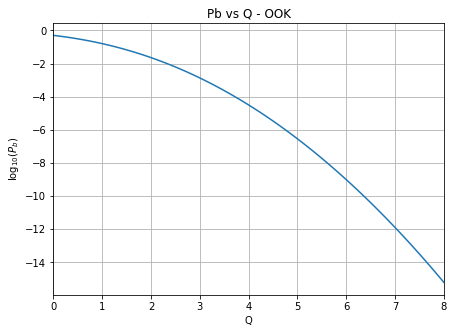

In [81]:
Q  = np.arange(0, 8.1, 0.1)
Pb = 0.5*erfc(Q/np.sqrt(2))

plt.figure(figsize=(7,5))
plt.plot(Q, np.log10(Pb),label='Pb')
plt.title('Pb vs Q - OOK')
plt.xlabel('Q')
plt.ylabel('$\log_{10}(P_b)$');
plt.xlim(min(Q),max(Q))
plt.grid()

#### Exemplo: simulação 10G OOK

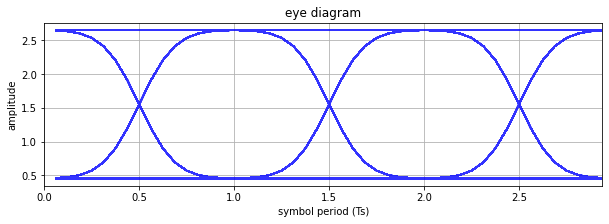

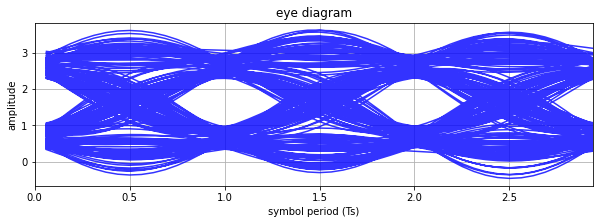

Pin[Rx] = -13.01 dBm 
SNR[sim] = 25.89 dB 

I0 = 0.66  
I1 = 2.64  
σ0 = 0.16  
σ1 = 0.16  
Limiar ótimo Id = 1.65  
Q = 6.06   

Total de erros contados = 0  
BER = 0.00e+00  
Pb = 7.00e-10  


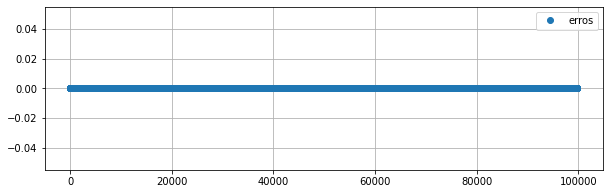

In [134]:
# parâmetros da simulação
SpS    = 16            # número de amostras por símbolo
Rs     = 10e9          # Taxa de símbolos (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequência de amostragem do sinal (amostras/segundo)
Ta     = 1/Fa          # Período de amostragem

Pi_dBm = -10  # potência de sinal óptico na entrada do modulador em dBm

# parâmetros do MZM
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # potência de sinal óptico em W na entrada do MZM

# parâmetros do receptor
Tc  = 25        # temperatura em Celsius
Rd  = 0.85      # responsividade em A/W
Id  = 5e-9      # corrente de escuro em nA
RL  = 50        # RL em Ohms
B   = 5e9       # banda do receptor em Hz

############# Simulação #############

### Transmissor

# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=100000)    
n        = np.arange(0, bitsTx.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bitsTx-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
pulse = pulseShape('nrz', SpS)
#pulse = pulseShape('rrc', SpS, alpha=0.001, N = 2048)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulação óptica
Ai     = np.sqrt(Pi)
sigTxo = mzm(Ai, Vπ, 0.5*sigTx, Vb)

### Receptor
Pin = (np.abs(sigTxo)**2).mean() # Potência óptica média média recebida

# fotocorrente livre de ruído
Ip = Rd*np.abs(sigTxo)**2

# ruído de disparo 
σ2_s = 2*q*(Rd*Pin + Id)*B  # variância  

# ruído térmico
T = Tc + 273.15     # temperatura em Kelvin
σ2_T = 4*kB*T*B/RL  # variância do ruído térmico

# adiciona ruído do receptor p-i-n aos sinais
Is   = normal(0, np.sqrt(Fa*(σ2_s/(2*B))), Ip.size)
It   = normal(0, np.sqrt(Fa*(σ2_T/(2*B))), Ip.size)  

I = Ip + Is + It

# filtragem Rx

# h = pulseShape('nrz', SpS)
# h = pulse/max(abs(h))
# h = pulseShape('rrc', SpS, alpha=0.001, N = 2048)

N = 8001
h = lowPassFIR(B, Fa, N, typeF='rect')

I_Rx  = firFilter(h, I)
I_Rx = I_Rx/np.std(I_Rx)

# calculando a SNR na simulação
Ip_Rx  = firFilter(h, Ip)
Is_Rx  = firFilter(h, Is)
It_Rx  = firFilter(h, It)

# gera sinal para visualizaçã do diagrama de olho
I_eye = I_Rx[100*SpS:I_Rx.size-100*SpS]

Nsamples = 10000
eyediagram(Ip/np.std(Ip),  Nsamples, SpS)
eyediagram(I_eye/np.std(I_eye), Nsamples, SpS)

# SNR estimada numericamente na simulação
SNR_est = np.var(Ip_Rx)/(np.var(Is_Rx) + np.var(It_Rx))

print('Pin[Rx] = %.2f dBm '%(10*np.log10(Pin/1e-3)))
print('SNR[sim] = %.2f dB \n'%(10*np.log10(SNR_est)))

# captura amostras no meio dos intervalos de sinalização
I_Rx  = I_Rx[0::SpS]

# obtém estatísticas do sinal recebido

I1 = np.mean(I_Rx[bitsTx==1]) # valor médio de I1
I0 = np.mean(I_Rx[bitsTx==0]) # valor médio de I0

σ1 = np.std(I_Rx[bitsTx==1]) # desvio padrão σ1 de I1 
σ0 = np.std(I_Rx[bitsTx==0]) # desvio padrão σ0 de I0 

Id = (σ1*I0 + σ0*I1)/(σ1 + σ0) # limiar de decisão ótimo
Q  = (I1-I0)/(σ1 + σ0)         # fator Q

print('I0 = %.2f  '%(I0))
print('I1 = %.2f  '%(I1))
print('σ0 = %.2f  '%(σ0))
print('σ1 = %.2f  '%(σ1))
print('Limiar ótimo Id = %.2f  '%(Id))
print('Q = %.2f   \n'%(Q))

# Aplica a regra de decisão ótima
bitsRx = np.empty(bitsTx.size)
bitsRx[I_Rx>  Id] = 1
bitsRx[I_Rx<= Id] = 0

discard = 100
err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

Pb = 0.5*erfc(Q/np.sqrt(2)) # probabilidade de erro teórica
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))
print('Pb = %.2e  '%(Pb))

plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()